## Midline analysis notebook
This notebook generates and analyze skeletons of fish extracted from data generated with [idtracker.ai](idtracker.ai) data.

This notebook requires to have scikit-image, mahotas and the fishmidline package (https://gitlab.com/polavieja_lab/midline) installed. 

If you use this code and/or data generated from [idtracker.ai](idtracker.ai), please cite:

**Romero-Ferrero, F., Bergomi, M.G., Hinz, R.C., Heras, F.J.H., de Polavieja, G.G., (2018). idtracker.ai: Tracking all individuals in large collectives of unmarked animals (under review) (F.R.-F. and M.G.B. contributed equally to this work. Correspondence should be addressed to G.G.d.P: gonzalo.polavieja@neuro.fchampalimaud.org)**

### Import the necessary python modules

In [14]:
import os
from tqdm import tqdm
import numpy as np
from fishmidline import get_midline_angles

### Set parameters

In [16]:
session_path = '../data/session_test'
dist_pts = 3 # in pixels
use_nose = True

### Load idtracker.ai objects

In [17]:
video_path = os.path.join(session_path, 'video_object.npy')
blobs_path = os.path.join(session_path, 'preprocessing',
                          'blobs_collection.npy')
print("Loading video information from {}".format(video_path))
video = np.load(video_path, allow_pickle=True).item()
print("Loading list_of_blobs from {}".format(blobs_path))
list_of_blobs = np.load(blobs_path, allow_pickle=True).item()

Loading video information from ../data/session_test/video_object.npy
Loading list_of_blobs from ../data/session_test/preprocessing/blobs_collection.npy


### Compute angles using the get_mideline_angles function from the package *fishmidline*

In [18]:
num_frames = video.number_of_frames
all_angles = np.zeros((num_frames, video.number_of_animals,
                       int(video.median_body_length // dist_pts))) * np.nan
len_angles = []
for frame_number in tqdm(range(num_frames), desc='computing...'):
    blobs_in_frame = list_of_blobs.blobs_in_video[frame_number]
    for blob in blobs_in_frame:
        if blob.is_an_individual:
            angles = get_midline_angles(video, blob,
                                        distance_between_points=dist_pts,
                                        use_nose=use_nose)
            len_angles.append(len(angles))
            if len(angles) < all_angles.shape[2]:
                all_angles[frame_number, blob.identity - 1,
                           :len(angles)] = angles
            else:
                all_angles[frame_number, blob.identity - 1,
                           :len(angles)] = angles[:all_angles.shape[2]]

computing...: 100%|██████████| 508/508 [03:28<00:00,  2.23it/s]


In [19]:
save_folder = os.path.join(session_path, 'angles')
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
np.save(os.path.join(save_folder, 'midline_angles.npy'), all_angles)

### Plot fish mideline extraction steps

In [20]:
def plotter(frame_number, binary_image, skeleton, nose, tail, contour,
            midline_xy, midline_interp_xy, midline_eq_xy,
            use_nose=False):
    if use_nose:
        fig, ax_arr = plt.subplots(2, 4, figsize=(15, 10))
    else:
        fig, ax_arr = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Frame {}".format(frame_number))
    x_lim = [np.min(np.where(binary_image)[1]) - 1,
             np.max(np.where(binary_image)[1]) + 1]
    y_lim = [np.min(np.where(binary_image)[0]) - 1,
             np.max(np.where(binary_image)[0]) + 1]
    # Plot binary image
    ax_arr[0, 0].imshow(binary_image, cmap='gray')
    ax_arr[0, 0].set_title('Segmented blob in binary full frame')
    # Plot zoomed binary image
    ax_arr[0, 1].imshow(binary_image, cmap='gray')
    ax_arr[0, 1].set_xlim(x_lim), ax_arr[0, 1].set_ylim(y_lim)
    ax_arr[0, 1].invert_yaxis()
    ax_arr[0, 1].set_title('(Zoom)')
    # Plot skeleton and nose
    ax_arr[0, 2].imshow(skeleton, cmap='gray')
    ax_arr[0, 2].plot(nose[0], nose[1], 'ro', markersize=3)
    ax_arr[0, 2].plot(tail[0], tail[1], 'bo', markersize=3)
    ax_arr[0, 2].set_xlim(x_lim), ax_arr[0, 2].set_ylim(y_lim)
    ax_arr[0, 2].invert_yaxis()
    ax_arr[0, 2].set_title('Skeleton from\nbinary image')
    # Plot contour and nose
    if use_nose:
        contour = np.squeeze(np.asarray(contour))
        ax_arr[0, 3].plot(contour[:, 0], contour[:, 1])
        ax_arr[0, 3].plot(nose[0], nose[1], 'ro')
        ax_arr[0, 3].plot(tail[0], tail[1], 'bo')
        ax_arr[0, 3].set_xlim(x_lim), ax_arr[0, 3].set_ylim(y_lim)
        ax_arr[0, 3].invert_yaxis()
        ax_arr[0, 3].set_aspect('equal')
        ax_arr[0, 3].set_title('Contour and\nfish nose\nand tail')
    # Plot midline points
    ax_arr[1, 0].plot(midline_xy[0], midline_xy[1], '.')
    ax_arr[1, 0].invert_yaxis()
    ax_arr[1, 0].set_aspect('equal')
    ax_arr[1, 0].set_title('Skeleton points')
    # Plot interpolated midline
    ax_arr[1, 1].plot(midline_interp_xy[0], midline_interp_xy[1], '-')
    ax_arr[1, 1].invert_yaxis()
    ax_arr[1, 1].set_aspect('equal')
    ax_arr[1, 1].set_title('Skeleton\ninterpolated')
    # Plot equidistant midline
    if use_nose:
        ax_arr[1, 2].plot(midline_eq_xy[0], midline_eq_xy[1], '-o')
        ax_arr[1, 2].invert_yaxis()
        ax_arr[1, 2].set_aspect('equal')
        ax_arr[1, 2].set_title('Equidistant points\nin skeleton')
    # Plot binary_image with ovelayed midline
    ax = ax_arr[1, 3] if use_nose else ax_arr[1, 2]
    ax.imshow(binary_image, cmap='gray')
    ax.plot(midline_eq_xy[0], midline_eq_xy[1], '-o')
    ax.plot(midline_eq_xy[0][0], midline_eq_xy[1][0], 'ro')
    ax.set_xlim(x_lim), ax.set_ylim(y_lim)
    ax.invert_yaxis()
    ax.set_title('Equispaced midline')

    return fig


In [21]:
import matplotlib.pyplot as plt
session_path = '../data/session_test'
use_nose = True
frame_number = 100
identity = 1

Loading video information from ../data/session_test/video_object.npy
Loading list_of_blobs from ../data/session_test/preprocessing/blobs_collection.npy
Identities in selected frame:  [2, 4, 6, 8, None, 1, 7]


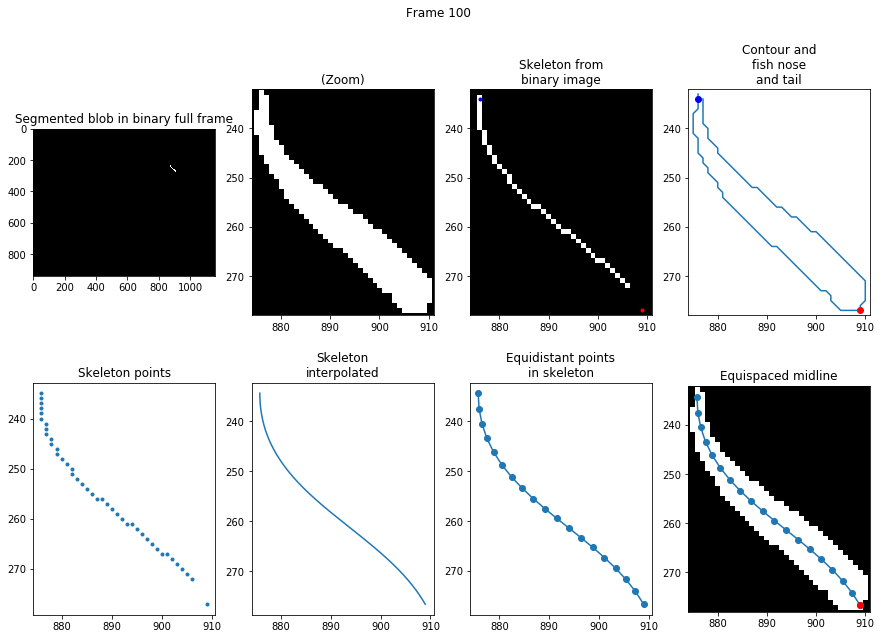

In [22]:
video_path = os.path.join(session_path, 'video_object.npy')
blobs_path = os.path.join(session_path, 'preprocessing',
                          'blobs_collection.npy')
print("Loading video information from {}".format(video_path))
video = np.load(video_path, allow_pickle=True).item()
print("Loading list_of_blobs from {}".format(blobs_path))
list_of_blobs = np.load(blobs_path, allow_pickle=True).item()

blobs_in_frame = list_of_blobs.blobs_in_video[frame_number]
identities = [blob.identity for blob in blobs_in_frame]
print("Identities in selected frame: ", identities)
if identity in identities:
    blob = [blob for blob in blobs_in_frame
            if blob.identity == identity][0]
    binary_image, skeleton, nose, tail, contour,\
        midline_xy, midline_interp_xy, midline_eq_xy, _ = \
        get_midline_angles(video, blob, plot_flag=True,
                           use_nose=use_nose)
    # # Plot images
    plotter(frame_number, binary_image, skeleton, nose, tail, contour,
            midline_xy, midline_interp_xy, midline_eq_xy,
            use_nose=use_nose)
else:
    print("No identity in this frame")

plt.show()

### Plot midline angles in time

In [72]:
midlines_angles = np.load(os.path.join(save_folder, 'midline_angles.npy'), allow_pickle=True)
first_frame, last_frame = 0, 200
identity = 8

(-3.141592653589793, 3.141592653589793)

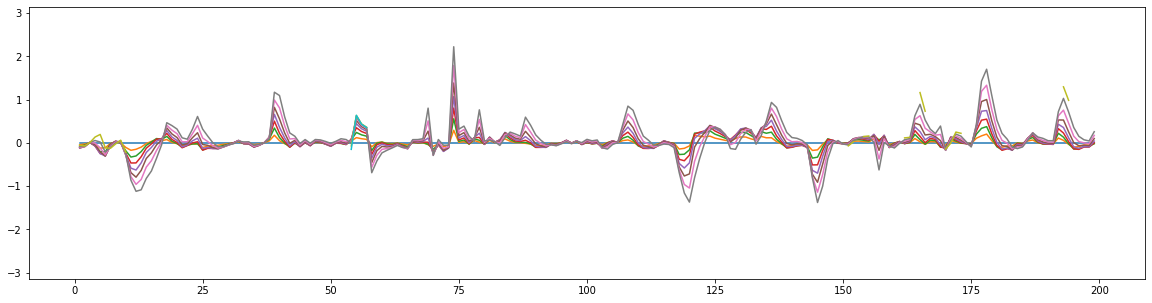

In [77]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
ax.plot(midlines_angles[first_frame:last_frame, identity-1, 0:20:2])
ax.set_ylim((-np.pi, np.pi))

### Plot distributions of angles for different segment-angles along the midline

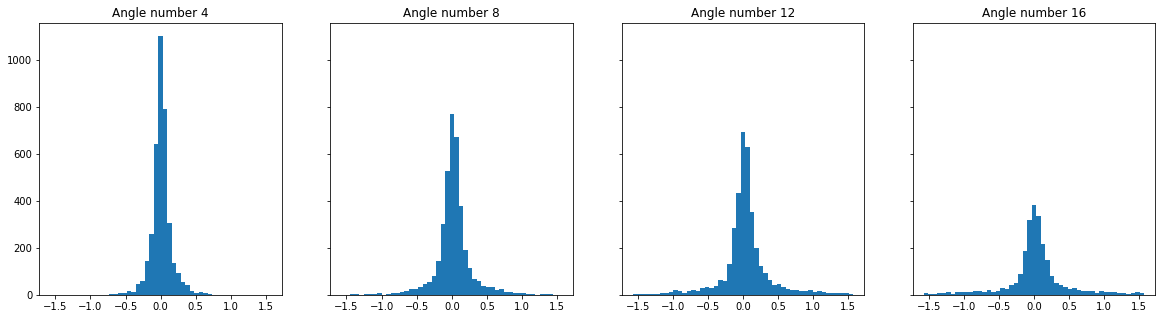

In [99]:
fig, ax_arr = plt.subplots(1, 4, figsize = (20, 5), sharex=True, sharey=True)
bins = np.linspace(-np.pi/2, np.pi/2, 50)
for i, angle_index in enumerate(range(4,20,4)):
    ax_arr[i].hist(midlines_angles[..., angle_index].flatten(), bins=bins)
    ax_arr[i].set_title('Angle number {}'.format(angle_index))